# Hourly Time Series Forecasting using XGBoost

[If you haven't already first check out my previous notebook forecasting on the same data using Prophet](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-prophet)

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

In [2]:
import os
# set working directory to root 
os.chdir('..')
os.getcwd()

'/home/qiangzibro/2021-math-model-code'

In [4]:
import pandas as pd, numpy as np
from common.io import load, load_table
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# Linux上解决字体问题
plt.rcParams['font.sans-serif']= ['Noto Serif CJK JP'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False 

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data

In [6]:
A = load_table("A")

In [9]:
df = A['1']

In [10]:
df.监测时间

0       2019-04-16 00:00:00
1       2019-04-16 01:00:00
2       2019-04-16 02:00:00
3       2019-04-16 03:00:00
4       2019-04-16 04:00:00
                ...        
19427   2021-07-13 03:00:00
19428   2021-07-13 04:00:00
19429   2021-07-13 05:00:00
19430   2021-07-13 06:00:00
19431   2021-07-13 07:00:00
Name: 监测时间, Length: 19432, dtype: datetime64[ns]

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [76]:
split_date = '2021-01-13'

train_data = df.loc[df.监测时间 <= split_date].copy()
test_data = df.loc[df.监测时间 > split_date].copy()

In [77]:
POLLUTIONS1 = ['SO2监测浓度(μg/m³)',
       'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)',
       'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']

# Create Time Series Features

In [78]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.监测时间
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'] +
            POLLUTIONS1[1:]
          ]
    if label:
        y = df[label]
        return X, y
    return X

In [79]:
X_train, y_train = create_features(train_data, label=POLLUTIONS1[0])
X_test, y_test = create_features(test_data, label=POLLUTIONS1[0])

/usr/miniconda3/envs/math/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [80]:
# _ = test_data \
#     .rename(columns={'PJME_MW': 'TEST SET'}) \
#     .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
#     .plot(figsize=(15,5), title='PJM East', style='.')

# Create XGBoost Model

In [81]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,NO2监测浓度(μg/m³),PM10监测浓度(μg/m³),PM2.5监测浓度(μg/m³),O3监测浓度(μg/m³),CO监测浓度(mg/m³)
0,0,1,2,4,2019,106,16,16,75,61,38,1,1.0
1,1,1,2,4,2019,106,16,16,64,60,41,25,0.8
2,2,1,2,4,2019,106,16,16,60,36,40,25,0.8
3,3,1,2,4,2019,106,16,16,39,35,33,41,0.7
4,4,1,2,4,2019,106,16,16,39,28,39,36,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15197,20,1,1,1,2021,12,12,2,74,45,29,11,0.8
15198,21,1,1,1,2021,12,12,2,78,42,35,7,0.9
15199,22,1,1,1,2021,12,12,2,80,48,37,4,1.0
15200,23,1,1,1,2021,12,12,2,77,50,45,3,1.0


In [82]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=5000,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=48, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

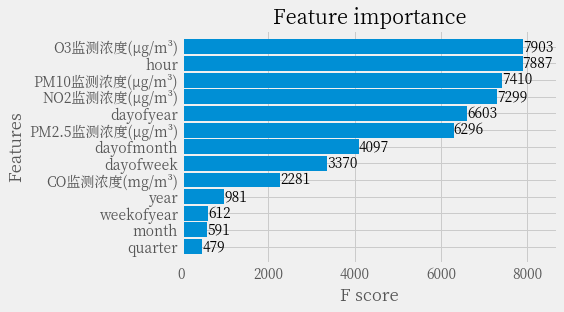

In [83]:
_ = plot_importance(reg, height=0.9, )

# Forecast on Test Set

In [84]:
test_data["预测的"+POLLUTIONS1[0]] = reg.predict(X_test)
all_data = pd.concat([test_data, train_data], sort=False)

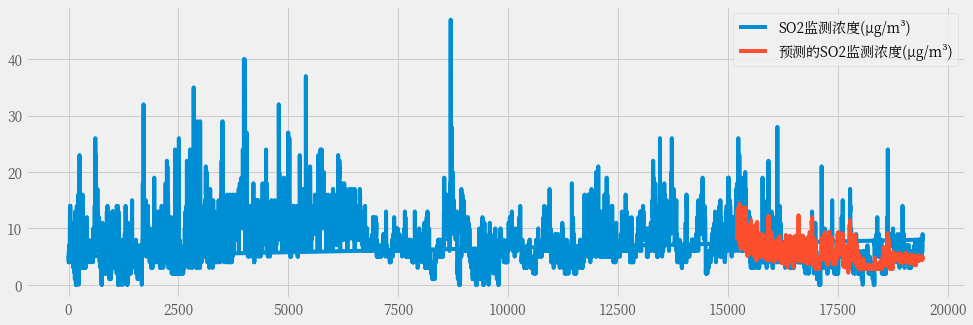

In [85]:
_ = all_data[[POLLUTIONS1[0],"预测的"+POLLUTIONS1[0]]].plot(figsize=(15, 5))

# Look at first month of predictions

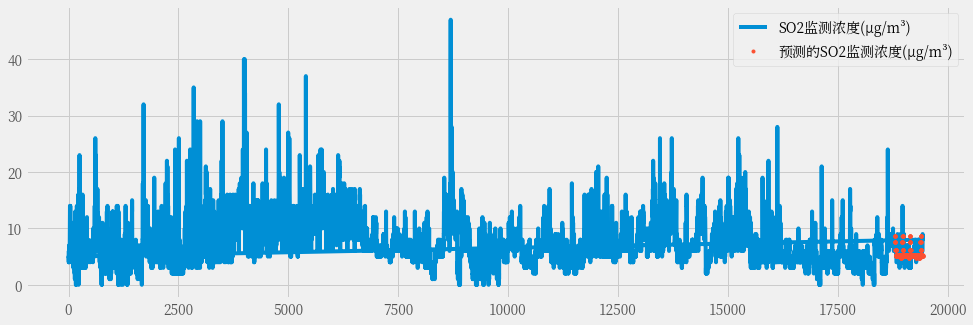

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[[POLLUTIONS1[0],"预测的"+POLLUTIONS1[0]]].plot(ax=ax,
                                              style=['-','.'])
# ax.set_xbound(lower='2021-06-13', upper='2021-07-13')
# ax.set_ylim(0, 60000)
# plot = plt.suptitle('January 2015 Forecast vs Actuals')

KeyError: "None of [Index(['MW_Prediction', 'PJME_MW'], dtype='object')] are in the [columns]"

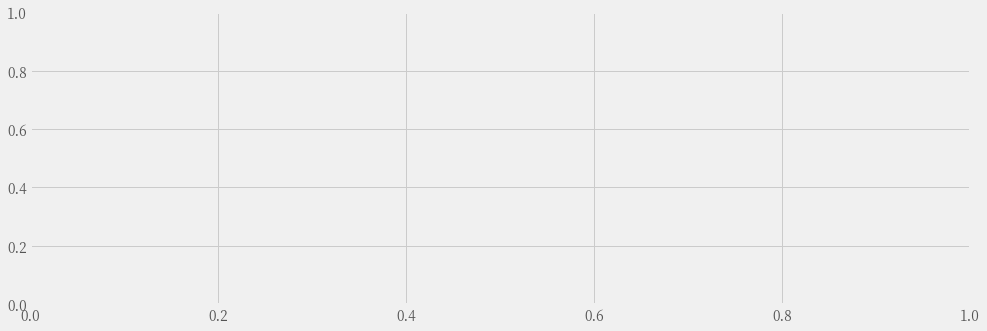

In [62]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2021-06-13', upper='2021-07-13')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [ ]:
mean_squared_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

In [ ]:
mean_absolute_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=test_data['PJME_MW'],
                   y_pred=test_data['MW_Prediction'])

# Look at Worst and Best Predicted Days

In [ ]:
test_data['error'] = test_data['PJME_MW'] - test_data['MW_Prediction']
test_data['abs_error'] = test_data['error'].apply(np.abs)
error_by_day = test_data.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

# Plotting some best/worst predicted days

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_data[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.